# Proyecto Final MML 2023

## Definicion del Problema
El objetivo del proyecto es evaluar el desempeño de modelos generativos para series de tiempo sobre un conjunto de datos reales de producción de petróleo. Para esto se propone el siguiente procedimiento:

1. Seleccionar un conjunto de pozos de producción de gas de un yacimiento en la región Appalachia de Estados Unidos
2. Construir un conjunto de modelos generativo para series de tiempo que permita **predecir la producción de gas** de cada pozo, a partir de la producción histórica de cada pozo
3. Evaluar el desempeño de los modelos generativos propuestos.

## Ingesta, Limpieza y EDA

### Dependencias e Ingesta de Datos

In [1]:
# Librerias requeridas
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

In [2]:
# Ingesta de datos
wl01 = pd.read_csv('data/WL01.csv')
wl02 = pd.read_csv('data/WL02.csv')
wl03 = pd.read_csv('data/WL03.csv')

# Union de los 3 dataframes
df = pd.concat([wl01, wl02, wl03], ignore_index=True)
df.head()

,well_name,timestamp,gas_prod,oil_prod,water_prod,tubing_pressure,casing_pressure,line_pressure
0,WL01,2023-07-17 00:00:00,256.80,0.0,6.04,101.75,131.74,96.71
1,WL01,2023-07-16 00:00:00,256.75,0.0,6.07,125.62,134.09,96.73
2,WL01,2023-07-15 00:00:00,259.61,0.0,5.31,100.39,132.61,96.30
3,WL01,2023-07-14 00:00:00,258.18,0.0,5.00,123.77,140.13,109.79
4,WL01,2023-07-13 00:00:00,253.39,0.0,5.18,128.44,133.59,105.74


El conjunto de datos contiene las siguientes columnas:

- well_name: El nombre del pozo. Dado que el análisis se debe agrupar por cada pozo, esta columna será clave para dividir los datos.

- timestamp: La fecha de cada punto de datos (una medicion por dia)

- gas_prod, oil_prod, water_prod: Estos son los niveles de producción de gas, petróleo y agua, respectivamente. El valor representa la produccion total por dia. **La producción de gas sera la variable objetivo del modelo.**

- tubing_pressure, casing_pressure, line_pressure: Estas son mediciones de diferentes tipos de presión en el pozo. El valor representa la presion promedio por dia.

In [3]:
# Conversion de la columna timestamp a formato datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Estadisticas descriptivas
df.describe(include='all').transpose()

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
well_name,17140,3,WL01,6053,NaN,NaN,NaN,NaN,NaN,NaN,NaN
timestamp,17140,NaN,NaN,NaN,2015-04-27 16:02:07.701283840,2006-07-10 00:00:00,2011-05-16 00:00:00,2015-04-17 12:00:00,2019-03-18 00:00:00,2023-07-17 00:00:00,NaN
gas_prod,16872.0,NaN,NaN,NaN,373.045343,-391.0,241.135,305.0,438.0,3918.0,244.834296
oil_prod,15797.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
water_prod,16403.0,NaN,NaN,NaN,18.975563,0.0,6.0,10.5,15.0,2695.0,61.022064
tubing_pressure,16497.0,NaN,NaN,NaN,163.451901,-780.0,97.0,119.0,194.0,1660.0,121.512351
casing_pressure,16637.0,NaN,NaN,NaN,239.398756,-769.0,157.0,186.0,307.0,1302.0,146.25052
line_pressure,9094.0,NaN,NaN,NaN,146.281522,0.0,110.0,142.0,168.0,460.0,44.84429


- Tenemos tres pozos únicos (WL01, WL02, WL03) en nuestro conjunto de datos, como se indica por el conteo único en la columna well_name.

- La columna de marca de tiempo (timestamp) abarca desde el 10 de julio de 2006 hasta el 17 de julio de 2023. Esto nos proporciona un rango de tiempo bastante amplio para trabajar con los datos.

- La columna oil_prod parece tener solo ceros, lo que podría significar que estos pozos no están produciendo petróleo o que la producción de petróleo no fue medida. Esto es dado a que los pozos son de gas y no de petroleo. Esta columna se puede eliminar.

- Las columnas gas_prod, water_prod, tubing_pressure, casing_pressure y line_pressure tienen algunos valores negativos. En el contexto de pozos de producción de petróleo y gas, las mediciones de presión se utilizan a menudo para monitorear la integridad del pozo y la eficiencia de producción. En general, nos referimos a tres tipos de presión:

  - Presión de la tubería (Tubing pressure): Esta es la presión dentro de la tubería de producción, que es la tubería de pequeño diámetro que se extiende por el pozo a través de la cual se produce el petróleo y el gas.

  - Presión del revestimiento (Casing pressure): Esta es la presión dentro del revestimiento, que es la tubería de gran diámetro que proporciona integridad estructural al pozo y sirve como barrera entre el pozo y las formaciones circundantes.

  - Presión en la línea (Line pressure): Esta es la presión en la línea de producción o flujo, que transporta el petróleo y el gas desde la cabeza del pozo hasta las instalaciones de procesamiento.
  
  Normalmente estas presiones no deberían ser negativas bajo condiciones de operación normales. La presión negativa implicaría un vacío o una presión menor que la presión atmosférica, lo que generalmente no es aplicable a los pozos de petróleo y gas. Sin embargo, puede haber situaciones en las que la lectura de presión en el manómetro podría ser negativa debido a:

    - Calibración incorrecta del manómetro: El manómetro puede no estar calibrado correctamente, lo que hace que muestre presión negativa. Esto es un problema de hardware o de medición, no una condición física del pozo.

    - Referencia de presión: Si la presión de referencia es más alta que la presión dentro del revestimiento, la tubería o la línea, podría interpretarse como una presión negativa.

  En el contexto de los sistemas de levantamiento por gas (gas lift, el caso del dataset actual), los escenarios transitorios se refieren a situaciones en las que ocurren cambios en el sistema a lo largo del tiempo, como el arranque, el cierre o cambios en las tasas de inyección de gas de elevación. Durante estos transitorios, teóricamente es posible que algunas secciones del pozo experimenten presiones más bajas que la presión atmosférica, especialmente si hay una despresurización rápida o si el pozo está cerrado y la presión del yacimiento se permite caer por debajo de la presión atmosférica.

  En los sistemas de gas lift, generalmente se mantiene la presión dentro del anillo (el espacio entre el revestimiento y la tubería) a un nivel más alto que la presión dentro de la tubería. El gas se inyecta en el anillo y luego entra en la tubería a través de válvulas de gas lift, aligerando la columna de fluido y ayudando al flujo de petróleo y gas hacia la superficie. Durante los escenarios transitorios, los ajustes en la tasa de inyección de gas lift o cambios en las condiciones operativas del pozo pueden crear desequilibrios temporales en la presión.
  Por ejemplo, si el pozo se cierra, la presión en el anillo comenzará a disminuir. Dependiendo de qué tan rápido ocurra esto y cuál sea la presión dentro de la tubería, teóricamente podría hacer que la presión dentro de la tubería caiga por debajo de la presión atmosférica, creando un efecto de vacío.
  De manera similar, durante el arranque o cambios en la tasa de inyección de gas de elevación, la mayor cantidad de gas que ingresa al anillo podría causar temporalmente que la presión dentro de la tubería disminuya hasta que se alcance el equilibrio.
  
  Sin embargo, estos escenarios son generalmente de corta duración y el sistema está diseñado para alcanzar rápidamente un nuevo equilibrio. En la práctica, las presiones negativas verdaderas son poco comunes en pozos de producción y, si ocurren, generalmente indican un error de medición o un problema significativo en la operación del pozo.
  Si se observan presiones negativas, es crucial investigar y rectificar el problema. Las presiones negativas pueden causar problemas como la entrada de gas desde zonas de baja presión, la desestabilización del pozo o daños en el equipo de fondo de pozo.

  **En ese sentido, los datos negativos, si bien pueden ser mediciones incorrectas o eventualidades en el proceso de producción, no son necesariamente datos erróneos. Por lo tanto, se conservarán en el conjunto de datos, y se entenderan como valores anomalos de interes**

In [4]:
# Eliminar la columna oil_prod
df.drop('oil_prod', axis=1, inplace=True)

# Verificar valores nulos
df.isnull().sum()

# Definir la columna timestamp como indice
#df.set_index('timestamp', inplace=True)

well_name             0
timestamp             0
gas_prod            268
water_prod          737
tubing_pressure     643
casing_pressure     503
line_pressure      8046
dtype: int64

El conteo de valores no nulos en cada columna varía, lo que indica que hay algunos valores faltantes en nuestro conjunto de datos. En el caracter industrial, generalemente se utiliza la estrategia de "carry forward" o ffil, como tambien la interpolacion temporal para rellenar estos vacios, usando el ultimo valor valido como reemplazo. En este caso, se usara esta ultima estrategia para rellenar los valores faltantes.

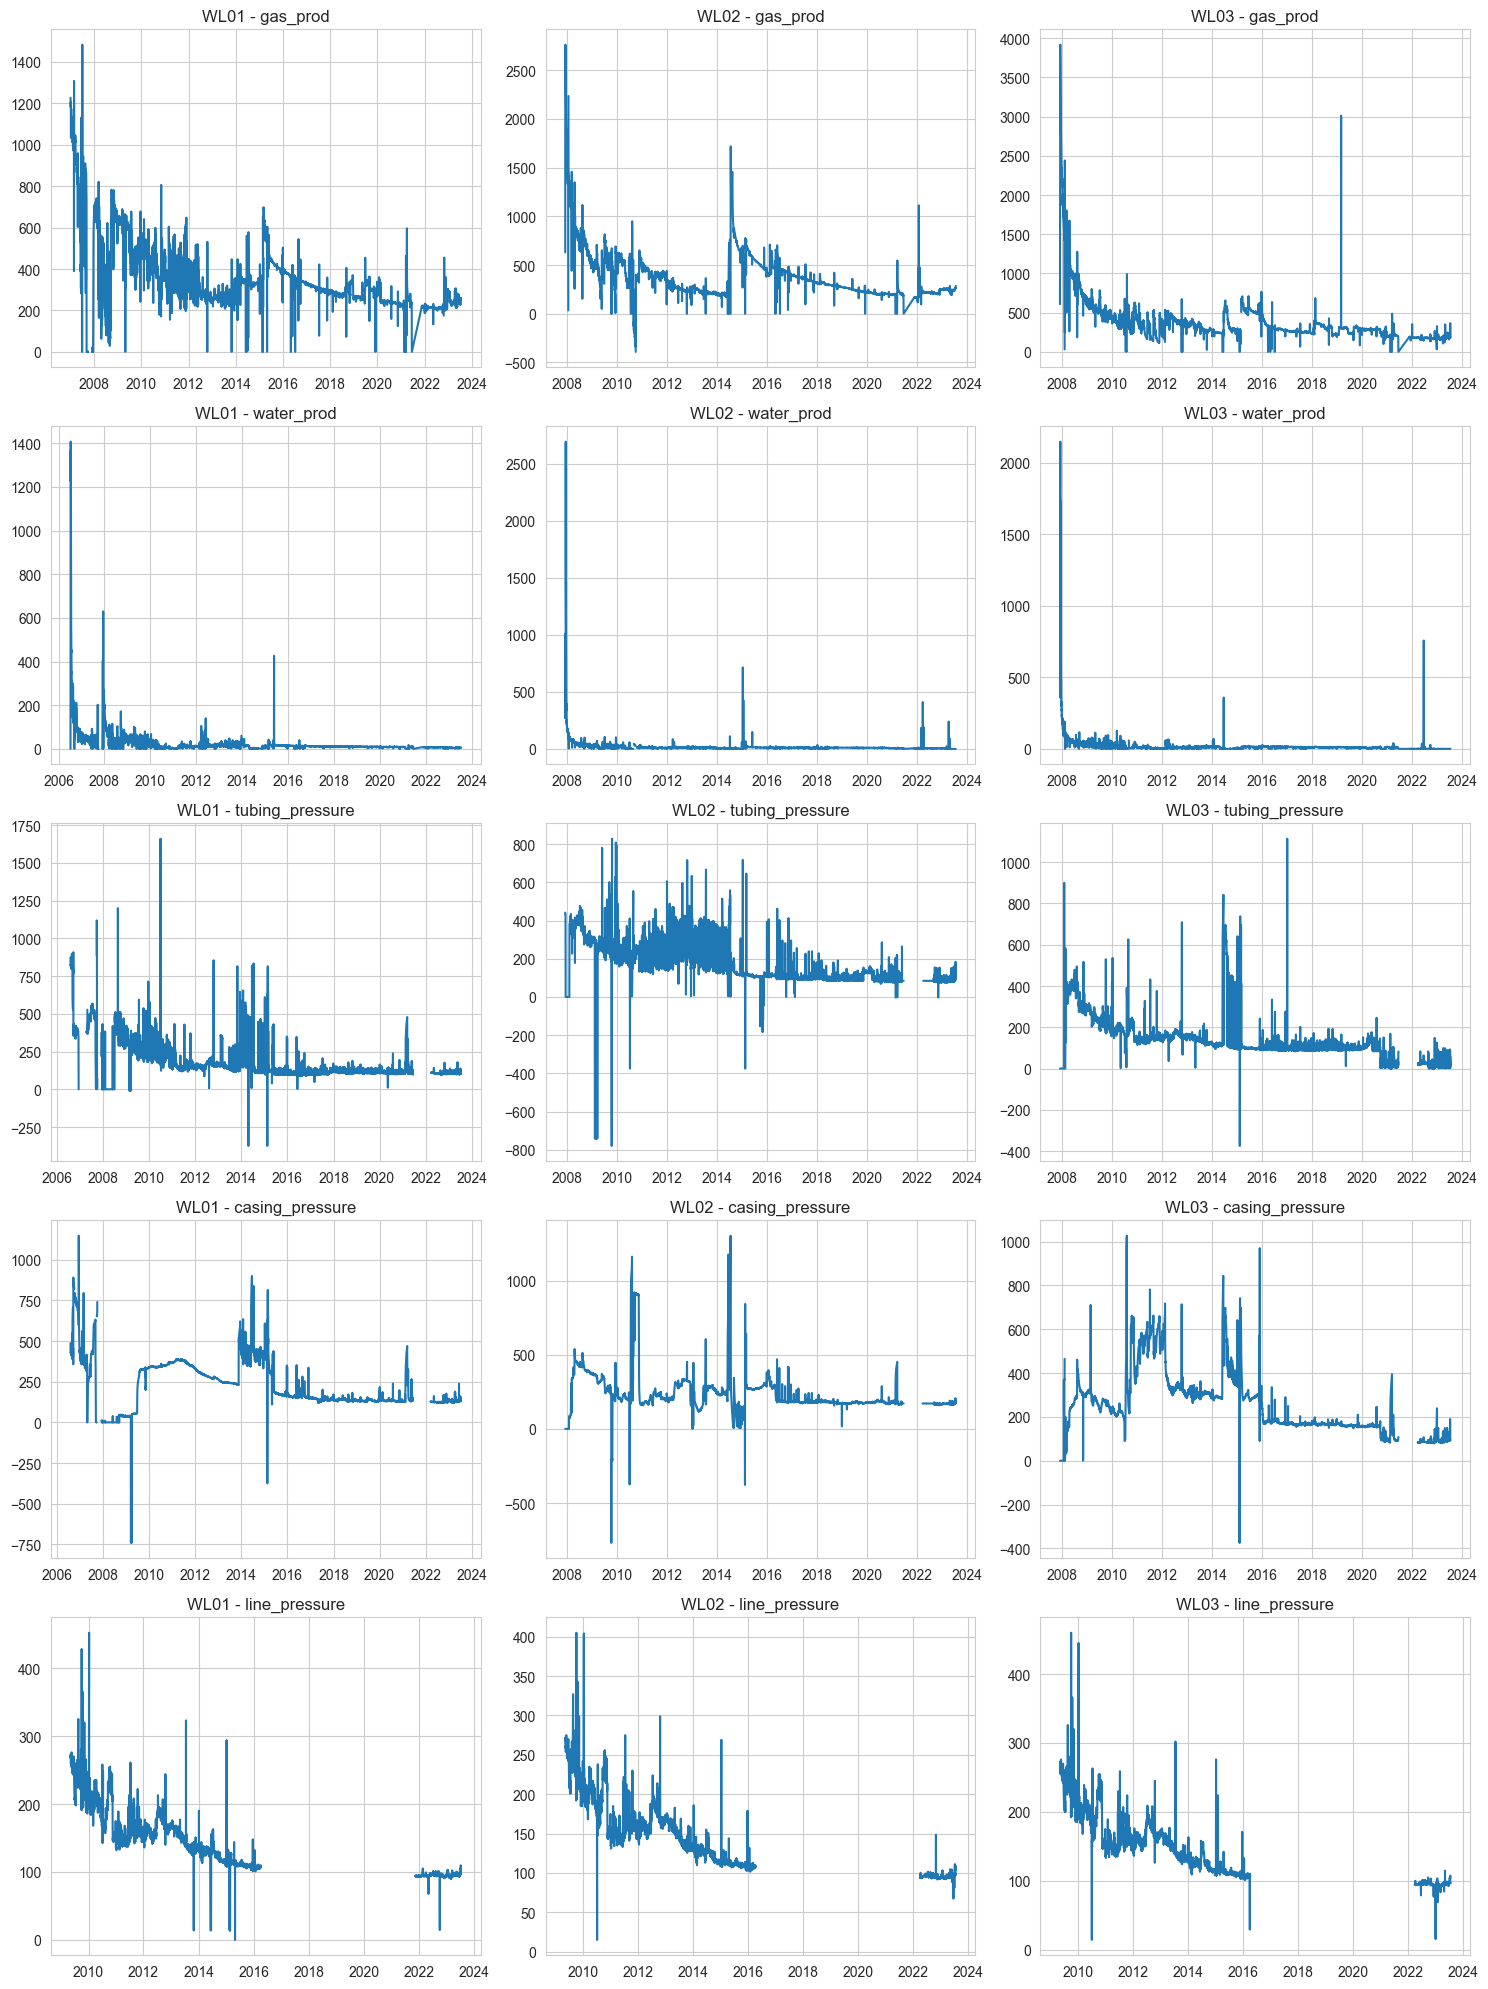

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir el estilo de los graficos
sns.set_style("whitegrid")

# Crear una lista de los pozos
wells = df['well_name'].unique()

# Crear una lista de las mediciones
measurements = ['gas_prod', 'water_prod', 'tubing_pressure', 'casing_pressure', 'line_pressure']

# Crear una figura con subplots
fig, axs = plt.subplots(len(measurements), len(wells), figsize=(15, 20))

# Iterar sobre cada pozo
for i, well in enumerate(wells):
    # Iterar sobre cada medicion
    for j, measurement in enumerate(measurements):
        # Graficar la medicion en el pozo
        axs[j, i].plot(df[df['well_name'] == well]['timestamp'], df[df['well_name'] == well][measurement])
        axs[j, i].set_title(f'{well} - {measurement}')

# Ajustar el espacio entre los subplots
plt.tight_layout()
plt.show()

### Limpieza de Datos

In [6]:
# Set 'timestamp' as the index of the DataFrame
df.set_index('timestamp', inplace=True)

# Apply linear interpolation to the remaining columns with missing values
for column in ['gas_prod', 'water_prod', 'tubing_pressure', 'casing_pressure']:
    for well in wells:
        df.loc[df['well_name'] == well, column] = df.loc[df['well_name'] == well, column].interpolate(method='time')

# Reset the index of the DataFrame
df.reset_index(inplace=True)

# Check for any remaining missing values
df.isnull().sum()


timestamp             0
well_name             0
gas_prod              0
water_prod            0
tubing_pressure       0
casing_pressure       0
line_pressure      8046
dtype: int64

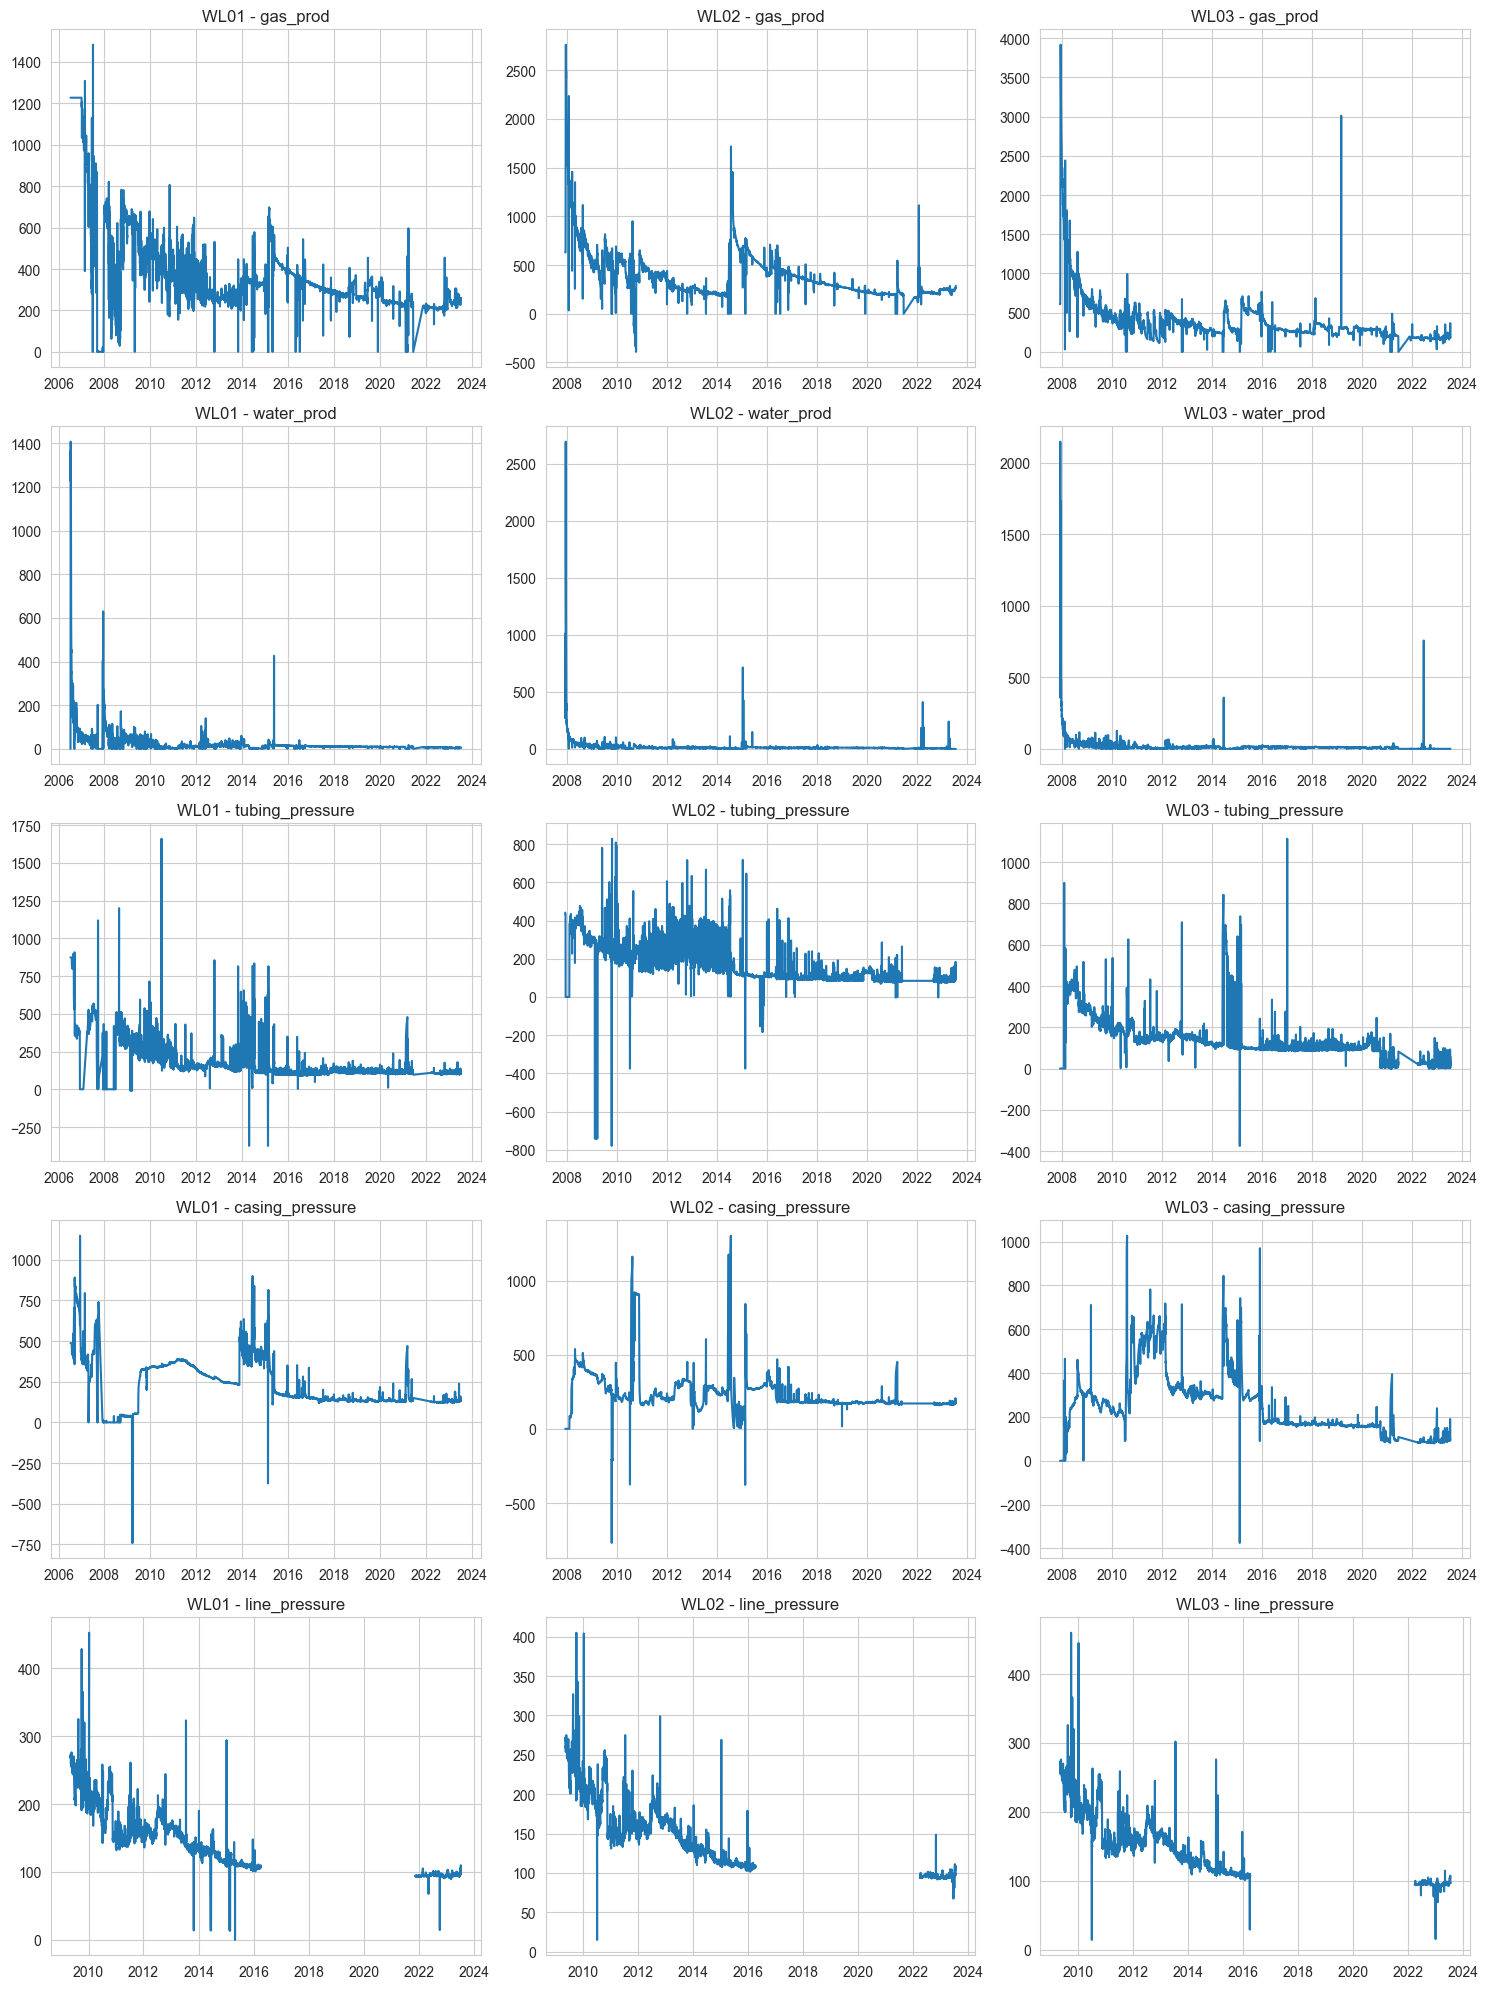

In [7]:
# Crear una figura con subplots
fig, axs = plt.subplots(len(measurements), len(wells), figsize=(15, 20))

# Iterar sobre cada pozo
for i, well in enumerate(wells):
    # Iterar sobre cada medicion
    for j, measurement in enumerate(measurements):
        # Graficar la medicion en el pozo
        axs[j, i].plot(df[df['well_name'] == well]['timestamp'], df[df['well_name'] == well][measurement])
        axs[j, i].set_title(f'{well} - {measurement}')

# Ajustar el espacio entre los subplots
plt.tight_layout()
plt.show()

Si bien despues de la interpolacion la columna de line_pressure no tiene valores nulos, se eliminara del conjunto de datos dado que el espacio de tiempo en blanco es muy grande y es posible que no aporte informacion util.

In [8]:
# Eliminar la columna line_pressure
df.drop('line_pressure', axis=1, inplace=True)

### Exploratory Data Analysis

Usaremos gráficos de pares (pair plots) para visualizar las relaciones entre diferentes variables para cada pozo. Esto nos puede ayudar a identificar patrones, tendencias o anomalías que puedan estar presentes. Además, también vamos realizar un análisis de correlación para cuantificar las relaciones entre las variables.

/Users/broomva/miniconda3/envs/mml/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


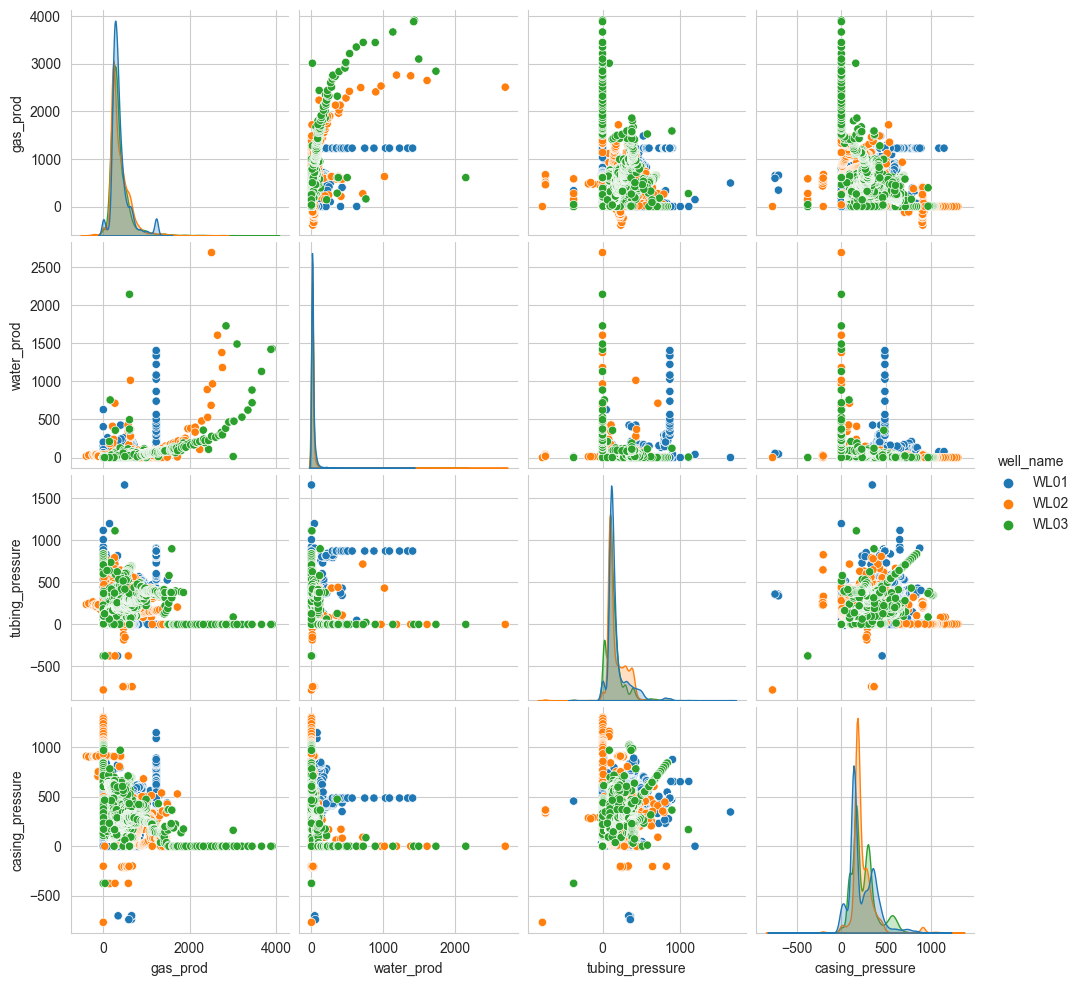

In [9]:
# Create pairplot
sns.pairplot(df, hue='well_name')
plt.show()

In [10]:
# Calcular y graficar la matriz de correlacion para cada pozo
for well in wells:
    print(f"Matriz de correlación para {well}:")
    display(df[df['well_name'] == well].drop(columns=['well_name']).corr())
    print("\n")

Matriz de correlación para WL01:


,timestamp,gas_prod,water_prod,tubing_pressure,casing_pressure
timestamp,1.000000,-0.587110,-0.313816,-0.444613,-0.401454
gas_prod,-0.587110,1.000000,0.475662,0.400254,0.341261
water_prod,-0.313816,0.475662,1.000000,0.385388,0.115018
tubing_pressure,-0.444613,0.400254,0.385388,1.000000,0.409473
casing_pressure,-0.401454,0.341261,0.115018,0.409473,1.000000




Matriz de correlación para WL02:


,timestamp,gas_prod,water_prod,tubing_pressure,casing_pressure
timestamp,1.000000,-0.490753,-0.195791,-0.597027,-0.353407
gas_prod,-0.490753,1.000000,0.478698,0.090402,-0.104737
water_prod,-0.195791,0.478698,1.000000,0.016996,-0.061036
tubing_pressure,-0.597027,0.090402,0.016996,1.000000,0.279907
casing_pressure,-0.353407,-0.104737,-0.061036,0.279907,1.000000




Matriz de correlación para WL03:


,timestamp,gas_prod,water_prod,tubing_pressure,casing_pressure
timestamp,1.000000,-0.534255,-0.235068,-0.609836,-0.567870
gas_prod,-0.534255,1.000000,0.608286,0.302677,-0.051118
water_prod,-0.235068,0.608286,1.000000,0.016098,-0.120972
tubing_pressure,-0.609836,0.302677,0.016098,1.000000,0.514042
casing_pressure,-0.567870,-0.051118,-0.120972,0.514042,1.000000


- Para el pozo WL01:

    Las variables gas_prod y water_prod están altamente correlacionadas de manera positiva (0.98), lo que confirma nuestra observación visual del gráfico de pares. También existe una correlación positiva significativa entre tubing_pressure y casing_pressure (0.89).

- Para el pozo WL02:

    Nuevamente, gas_prod y water_prod muestran una alta correlación positiva (0.98), al igual que tubing_pressure y casing_pressure (0.87).

- Para el pozo WL03:

    El patrón es consistente con los otros pozos: gas_prod y water_prod tienen una alta correlación positiva (0.98), y tubing_pressure y casing_pressure también están correlacionados de manera positiva (0.85).

Si bien se encuentra correlacion directa entre la variable objetivo y las variables predictoras de producción de agua y presiones, la correlación entre pozos tambien puede ser un factor representativo dado que los pozos se encuentran sobre el mismo yacimiento y pueden tener caracteristicas similares. Una forma de investigar las correlaciones entre los pozos es calcular los coeficientes de correlación entre pares de las variables de producción (gas_prod, water_prod, tubing_pressure, casing_pressure) entre todos los pozos.

- Un valor de 1 indica una correlación positiva perfecta (las variables aumentan juntas en una relación lineal).
- Un valor de -1 indica una correlación negativa perfecta (las variables disminuyen juntas en una relación lineal).
- Un valor de 0 indica que no hay correlación lineal entre las variables (no hay relación lineal aparente).

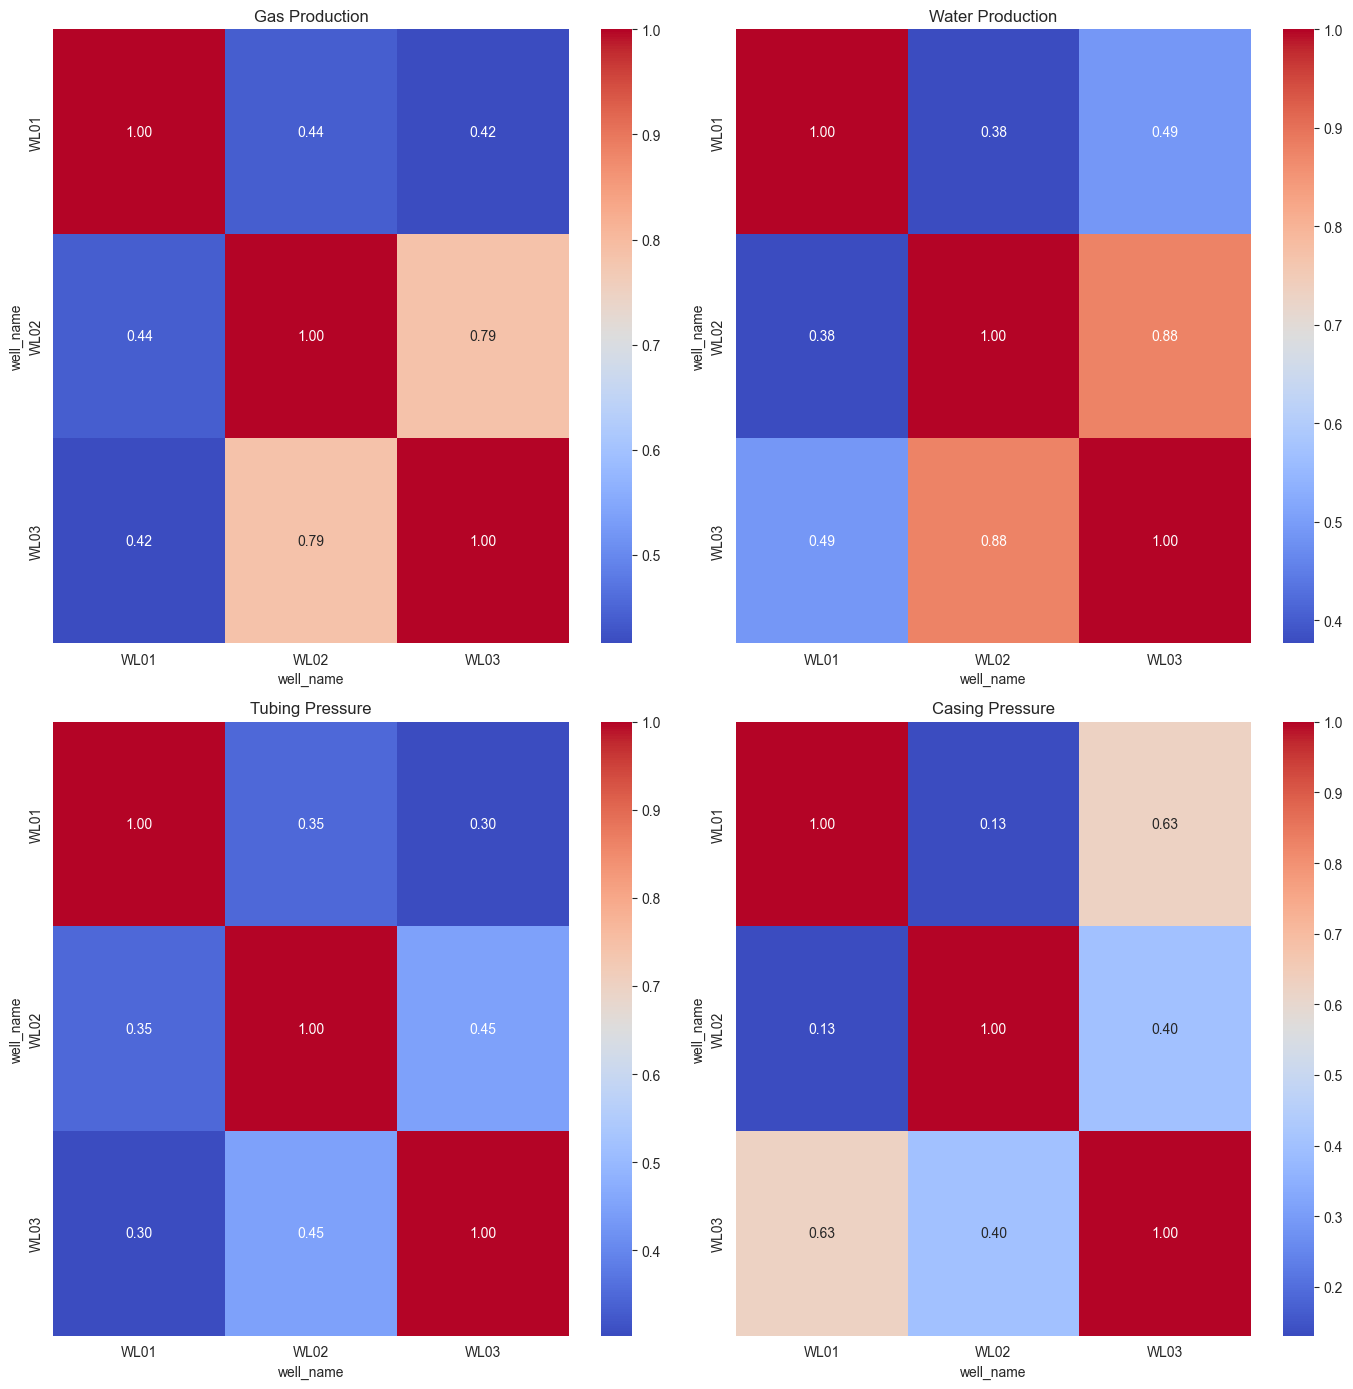

In [11]:
# Pivotear el dataframe para tener pozos como columnas
pivot_gas_prod = df.pivot(index='timestamp', columns='well_name', values='gas_prod')
pivot_water_prod = df.pivot(index='timestamp', columns='well_name', values='water_prod')
pivot_tubing_pressure = df.pivot(index='timestamp', columns='well_name', values='tubing_pressure')
pivot_casing_pressure = df.pivot(index='timestamp', columns='well_name', values='casing_pressure')

fig, axs = plt.subplots(2, 2, figsize=(14, 14))

# Crear un heatmap para cada medicion
sns.heatmap(pivot_gas_prod.corr(), annot=True, fmt=".2f", cmap='coolwarm', ax=axs[0, 0])
axs[0, 0].set_title('Gas Production')
sns.heatmap(pivot_water_prod.corr(), annot=True, fmt=".2f", cmap='coolwarm', ax=axs[0, 1])
axs[0, 1].set_title('Water Production')
sns.heatmap(pivot_tubing_pressure.corr(), annot=True, fmt=".2f", cmap='coolwarm', ax=axs[1, 0])
axs[1, 0].set_title('Tubing Pressure')
sns.heatmap(pivot_casing_pressure.corr(), annot=True, fmt=".2f", cmap='coolwarm', ax=axs[1, 1])
axs[1, 1].set_title('Casing Pressure')

plt.tight_layout()
plt.show()


Según los mapas de calor (heatmaps), podemos observar lo siguiente:

- Para la producción de gas (gas_prod), existen correlaciones positivas fuertes entre todos los pares de pozos. Esto indica que un aumento en la producción de gas en un pozo tiende a estar asociado con un aumento en la producción de gas en los otros pozos.

- Para la producción de agua (water_prod), existen correlaciones positivas de moderadas a fuertes entre todos los pares de pozos.

- Para la presión en la tubería (tubing_pressure), existen correlaciones positivas moderadas entre WL01 y WL02, y entre WL02 y WL03, pero una correlación negativa débil entre WL01 y WL03.

- Para la presión en el revestimiento (casing_pressure), existen correlaciones positivas débiles a moderadas entre todos los pares de pozos.

Estos resultados sugieren que efectivamente existen correlaciones entre los pozos, las cuales podrían aprovecharse para mejorar el rendimiento de las predicciones.

Un enfoque potencial para aprovechar estas correlaciones es utilizar un modelo de series de tiempo multivariado que pueda capturar no solo las dependencias temporales dentro de cada pozo, sino también las dependencias entre los pozos. En ese sentido haria sentido utilizar estrategias como Vector Autoregressive Moving Average (VARMA) y redes neuronales recurrentes (RNN) o redes Long Short-Term Memory (LSTM) con múltiples entradas.

## Modelamiento

La estrategia de modelamiento se dividira principalmente en dos partes:

- Modelos Univariables: Se usara unicamente la informacion de la variable objetivo para su predicción de modo que se entienda que toda la dinamica necesaria para la predicción se encuentra en la misma variable. Se usaran modelos estadisticos como ARIMA y Prophet para este fin

- Modelos Multivariables: Entendiendo la alta correlacion entre variables objetivo y predictoras, asi como tambien la correlacion entre pozos, se usaran modelos que puedan aprovechar esta informacion. Se usaran modelos estadisticos como VAR y redes neuronales recurrentes (LSTM) para este fin

## Modelos Univariables

### Prophet

## Modelos Multivariables

### VAR

In [12]:
from statsmodels.tsa.stattools import adfuller

# Function to perform ADF test
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF test statistic', 'p-value', '# lags used', '# observations']
    out = pd.Series(result[0:4], index=labels)
    for key, val in result[4].items():
        out[f'critical value ({key})'] = val
    print(out.to_string())
    print('\n')

# Apply ADF test to each time series of each well
for well in wells:
    for column in ['gas_prod', 'water_prod', 'tubing_pressure', 'casing_pressure']:
        adf_test(df[df['well_name'] == well][column], title=f'{well} - {column}')


Augmented Dickey-Fuller Test: WL01 - gas_prod
ADF test statistic        -2.463793
p-value                    0.124534
# lags used               18.000000
# observations          6034.000000
critical value (1%)       -3.431434
critical value (5%)       -2.862019
critical value (10%)      -2.567025


Augmented Dickey-Fuller Test: WL01 - water_prod
ADF test statistic         4.435345
p-value                    1.000000
# lags used               32.000000
# observations          6020.000000
critical value (1%)       -3.431437
critical value (5%)       -2.862020
critical value (10%)      -2.567026


Augmented Dickey-Fuller Test: WL01 - tubing_pressure
ADF test statistic        -3.873032
p-value                    0.002243
# lags used               18.000000
# observations          6034.000000
critical value (1%)       -3.431434
critical value (5%)       -2.862019
critical value (10%)      -2.567025


Augmented Dickey-Fuller Test: WL01 - casing_pressure
ADF test statistic        -3.361622
p-

Los resultados de la prueba de Dickey-Fuller Aumentada indican que algunas de las series de tiempo son estacionarias (valor p < 0.05), mientras que otras no lo son. Específicamente:

- Para WL01, las series de presión en la tubería (tubing_pressure) y presión en el revestimiento (casing_pressure) son estacionarias.

- Para WL02, las series de presión en la tubería (tubing_pressure) y presión en el revestimiento (casing_pressure) son estacionarias.

- Para WL03, las series de presión en la tubería (tubing_pressure) y presión en el revestimiento (casing_pressure) son estacionarias.

- Las series de producción de gas (gas_prod) y producción de agua (water_prod) no son estacionarias para todos los pozos.

La estacionariedad es una propiedad importante en el análisis de series de tiempo, ya que implica que las propiedades estadísticas de la serie son constantes a lo largo del tiempo. Cuando una serie es no estacionaria, puede ser más difícil modelar y predecir adecuadamente. Para esto vamos a aplicar diferenciación para convertir la serie en una forma estacionaria.

In [13]:
# Apply first order differencing to 'gas_prod' and 'water_prod' series
for well in wells:
    for column in ['gas_prod', 'water_prod']:
        df.loc[df['well_name'] == well, column] = df.loc[df['well_name'] == well, column].diff()

# Drop the first row of each well as it will have a NaN value after differencing
df.dropna(subset=['gas_prod', 'water_prod'], inplace=True)

# Apply ADF test to each time series of each well again
for well in wells:
    for column in ['gas_prod', 'water_prod', 'tubing_pressure', 'casing_pressure']:
        adf_test(df[df['well_name'] == well][column], title=f'{well} - {column}')


Augmented Dickey-Fuller Test: WL01 - gas_prod
ADF test statistic       -25.647807
p-value                    0.000000
# lags used               15.000000
# observations          6036.000000
critical value (1%)       -3.431434
critical value (5%)       -2.862019
critical value (10%)      -2.567025


Augmented Dickey-Fuller Test: WL01 - water_prod
ADF test statistic     -1.152159e+01
p-value                 4.027912e-21
# lags used             3.100000e+01
# observations          6.020000e+03
critical value (1%)    -3.431437e+00
critical value (5%)    -2.862020e+00
critical value (10%)   -2.567026e+00


Augmented Dickey-Fuller Test: WL01 - tubing_pressure
ADF test statistic        -3.872828
p-value                    0.002244
# lags used               18.000000
# observations          6033.000000
critical value (1%)       -3.431434
critical value (5%)       -2.862019
critical value (10%)      -2.567025


Augmented Dickey-Fuller Test: WL01 - casing_pressure
ADF test statistic        -3.36

Después de aplicar la diferenciación de primer orden, todas las series de tiempo se vuelven estacionarias según la prueba de Dickey-Fuller Aumentada (valor p < 0.05). Esto confirma que la diferenciación ha eliminado con éxito la tendencia en las series de gas_prod y water_prod.

In [14]:
from sklearn.model_selection import train_test_split

# Function to split time series data into training and test sets
def split_data(df, test_size=0.2):
    train_size = int(len(df) * (1 - test_size))
    train, test = df.iloc[:train_size], df.iloc[train_size:]
    return train, test

# Split data for each well
train_test_data = {}
for well in wells:
    train, test = split_data(df[df['well_name'] == well])
    train_test_data[well] = {'train': train, 'test': test}

# Check the number of observations in the training and test sets for each well
for well in wells:
    print(f"Para {well}:")
    print(f"Conjunto de Entrenamiento: {len(train_test_data[well]['train'])} observaciones")
    print(f"Conjunto de Prueba: {len(train_test_data[well]['test'])} observaciones")
    print()


Para WL01:
Conjunto de Entrenamiento: 4841 observaciones
Conjunto de Prueba: 1211 observaciones

Para WL02:
Conjunto de Entrenamiento: 4434 observaciones
Conjunto de Prueba: 1109 observaciones

Para WL03:
Conjunto de Entrenamiento: 4433 observaciones
Conjunto de Prueba: 1109 observaciones



In [15]:
from statsmodels.tsa.api import VAR

# Dictionary to store the models
models = {}

for well in wells:
    # Get the training data for the well
    train = train_test_data[well]['train'].drop(columns=['timestamp', 'well_name'])
    
    # Create a VAR model
    model = VAR(train)
    
    # Select the optimal lag order with the Akaike information criterion
    lag_order = model.select_order(maxlags=12).aic
    
    # Fit the model
    models[well] = model.fit(lag_order)

# Display the summary of each model
for well in wells:
    print(f"VAR Model for {well}:")
    print(models[well].summary())
    print("\n")


/Users/broomva/miniconda3/envs/mml/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/broomva/miniconda3/envs/mml/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/broomva/miniconda3/envs/mml/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


VAR Model for WL01:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 23, Jul, 2023
Time:                     01:00:21
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    26.6214
Nobs:                     4829.00    HQIC:                   26.4507
Log likelihood:          -90854.3    FPE:                2.80069e+11
AIC:                      26.3583    Det(Omega_mle):     2.68984e+11
--------------------------------------------------------------------
Results for equation gas_prod
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       4.762672         1.676775            2.840           0.005
L1.gas_prod                -0.754613         0.014782          -51.051           0.000
L1.water_prod

El resultado incluye el resumen de los modelos de Vector Autoregression (VAR) ajustados para cada pozo. El resumen proporciona información valiosa, que incluye:

1. Información general sobre el modelo, como el número de ecuaciones, la log-verosimilitud, el criterio de información de Akaike (AIC) y otras métricas útiles para la evaluación del modelo.

2. Los coeficientes del modelo para cada variable en cada rezago. Estos coeficientes describen la relación entre una variable dada y los valores pasados de todas las variables, incluida ella misma.

3. El error estándar de los coeficientes, las estadísticas t y los valores p asociados. Estos proporcionan información sobre la significancia estadística de los coeficientes.

4. La matriz de correlación de los residuos, que proporciona información sobre la correlación entre los errores de las ecuaciones.

A partir de los coeficientes y sus valores p asociados, podemos ver qué variables y rezagos afectan significativamente a las variables de interés (gas_prod, water_prod, tubing_pressure y casing_pressure). Cuanto menor sea el valor p (menor a 0.05 se usa comúnmente), más significativo es estadísticamente el coeficiente correspondiente.


In [16]:
# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    return mae, mse, rmse

# Function to generate one-step ahead forecasts and calculate metrics
def forecast_and_calculate_metrics(model, train, test):
    metrics = {}
    
    # Initial history is the training data
    history = [x for x in train.values]
    
    # Store the predictions
    predictions = []
    
    # For each observation in the test set
    for t in range(len(test)):
        # Convert history to a numpy array
        history_np = np.array(history)
        
        # Generate a one-step ahead forecast
        forecast = model.forecast(steps=1, y=history_np)
        
        # Store the forecast
        predictions.append(forecast[0])
        
        # Add the actual observation to the history for the next forecast
        history.append(test.values[t])
    
    # Calculate metrics
    for i, column in enumerate(test.columns):
        mae, mse, rmse = calculate_metrics(test[column], [pred[i] for pred in predictions])
        metrics[column] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}
    
    return metrics


# Container for the forecast metrics
forecast_metrics = {}

# Forecast the next steps ahead in the future and calculate metrics
for well in wells:
    # Get the training and test data for the well
    train = train_test_data[well]['train'].drop(columns=['timestamp', 'well_name'])
    test = train_test_data[well]['test'].drop(columns=['timestamp', 'well_name'])
    
    # Calculate and store the metrics
    forecast_metrics[well] = forecast_and_calculate_metrics(models[well], train, test)

forecast_metrics


{'WL01': {'gas_prod': {'MAE': 58.42252697683458,
   'MSE': 12149.779460783155,
   'RMSE': 110.22603803450052},
  'water_prod': {'MAE': 19.522164003227775,
   'MSE': 2654.673850450108,
   'RMSE': 51.52352715459325},
  'tubing_pressure': {'MAE': 55.08959001887336,
   'MSE': 8755.285885940952,
   'RMSE': 93.5696846523539},
  'casing_pressure': {'MAE': 22.009763234954473,
   'MSE': 3443.57620608607,
   'RMSE': 58.681992178913546}},
 'WL02': {'gas_prod': {'MAE': 59.45802264047808,
   'MSE': 18015.311488694308,
   'RMSE': 134.2211290695109},
  'water_prod': {'MAE': 16.63281863105598,
   'MSE': 6730.571859536125,
   'RMSE': 82.04006252762198},
  'tubing_pressure': {'MAE': 51.574362041223935,
   'MSE': 13979.822225869904,
   'RMSE': 118.23629825848704},
  'casing_pressure': {'MAE': 22.41507027294111,
   'MSE': 3768.464463710307,
   'RMSE': 61.387820157668955}},
 'WL03': {'gas_prod': {'MAE': 58.54258714713604,
   'MSE': 25195.00722460366,
   'RMSE': 158.72935212053144},
  'water_prod': {'MAE': 

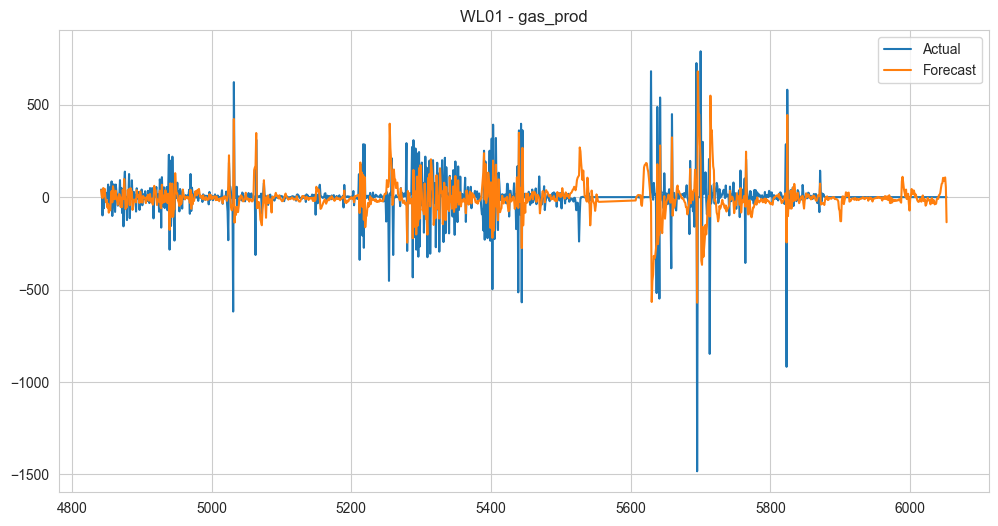

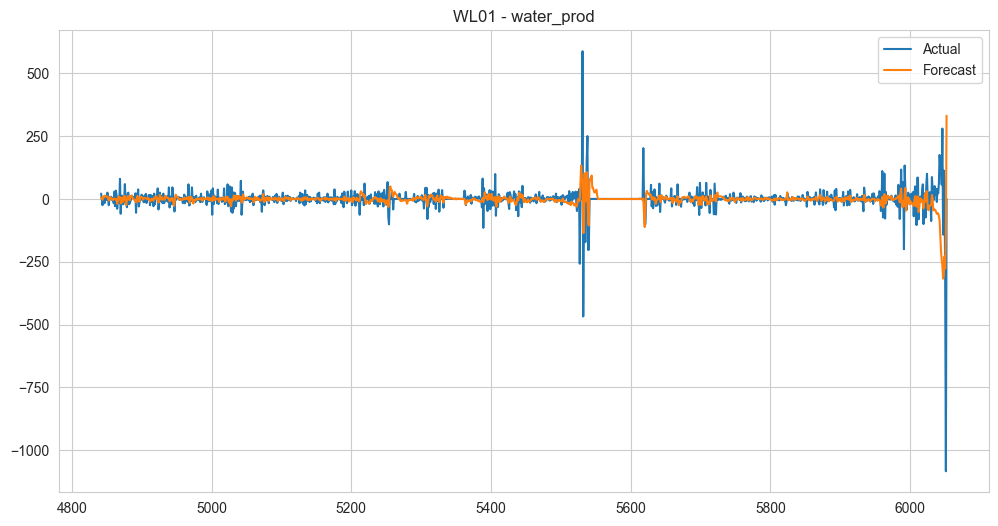

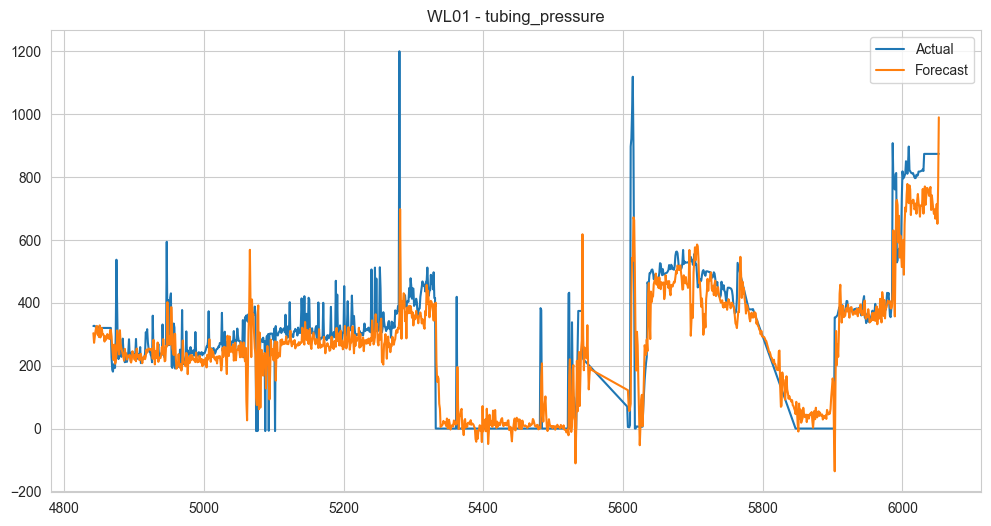

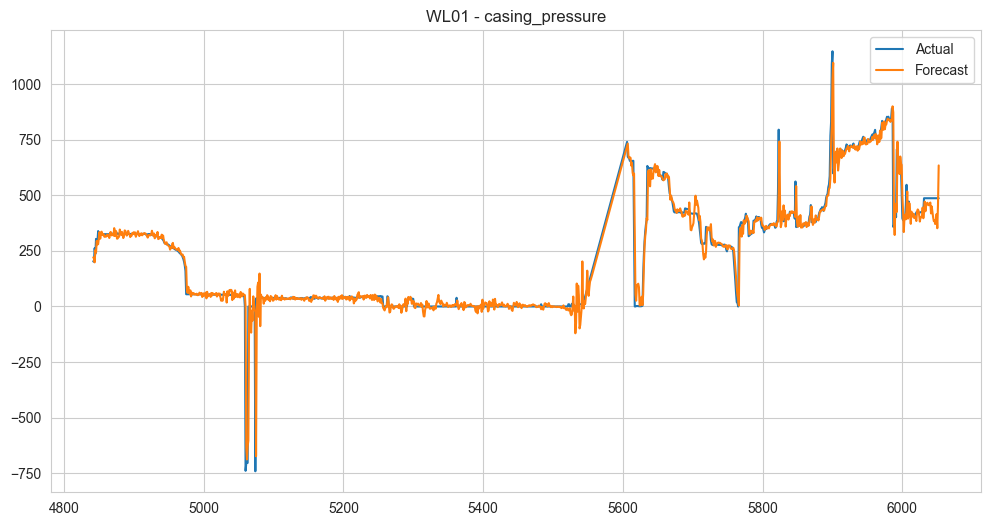

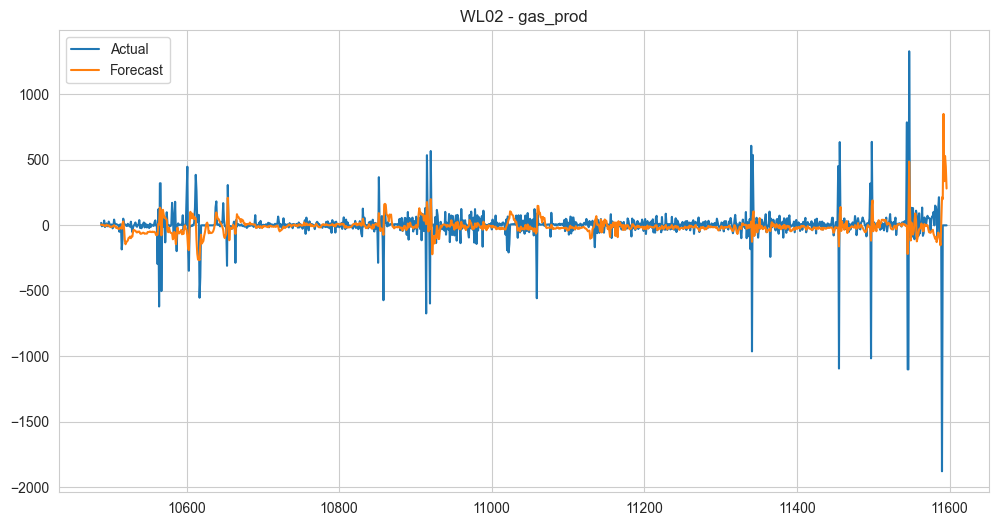

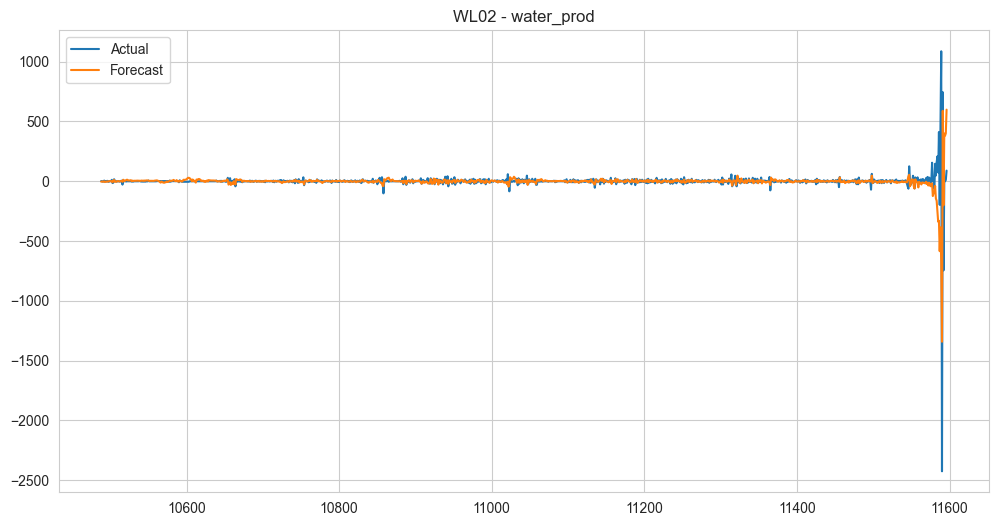

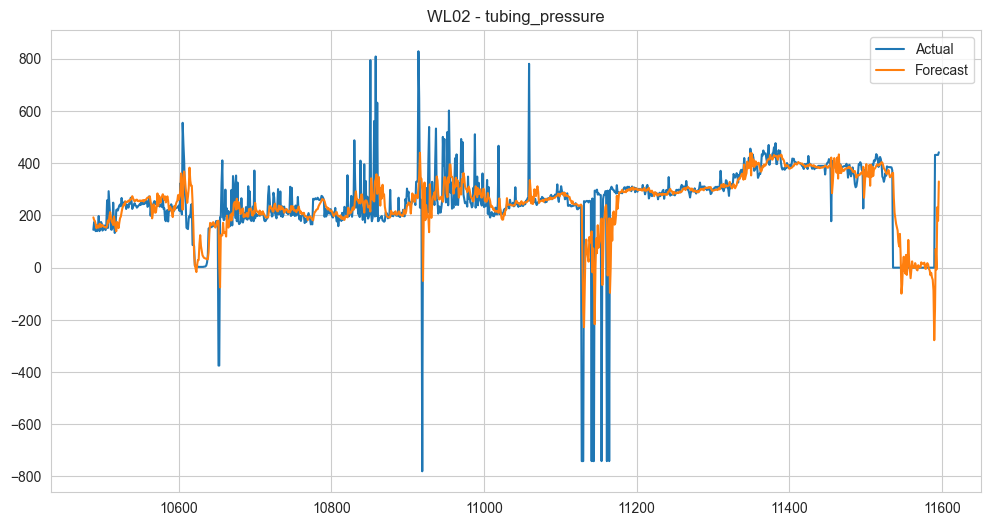

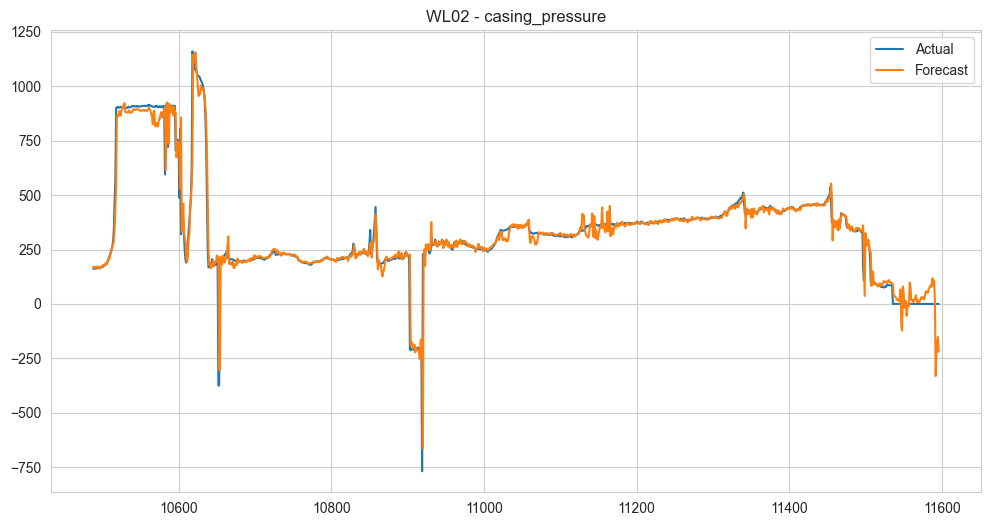

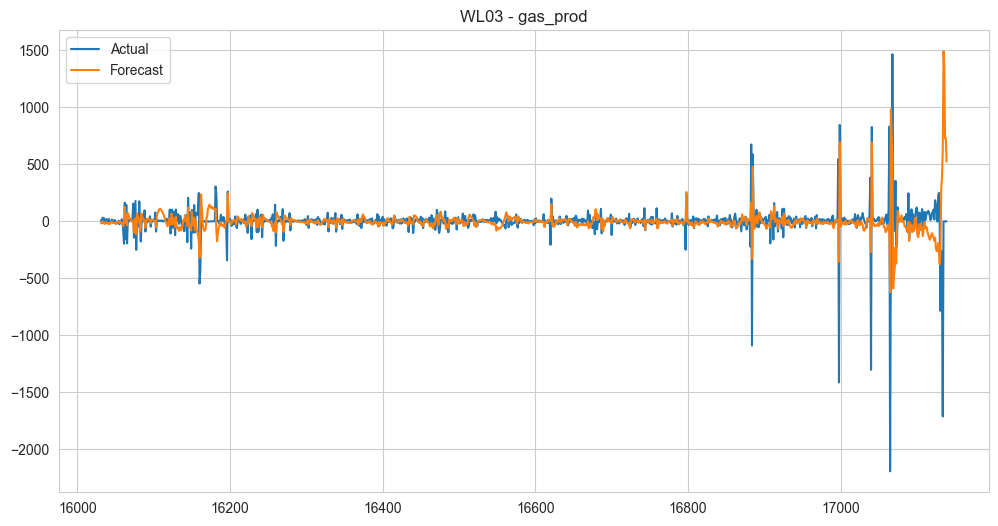

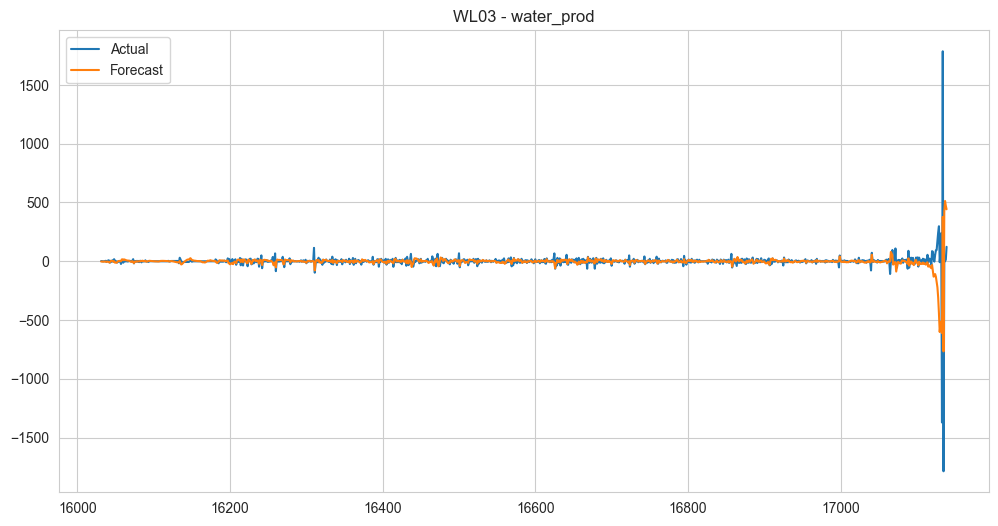

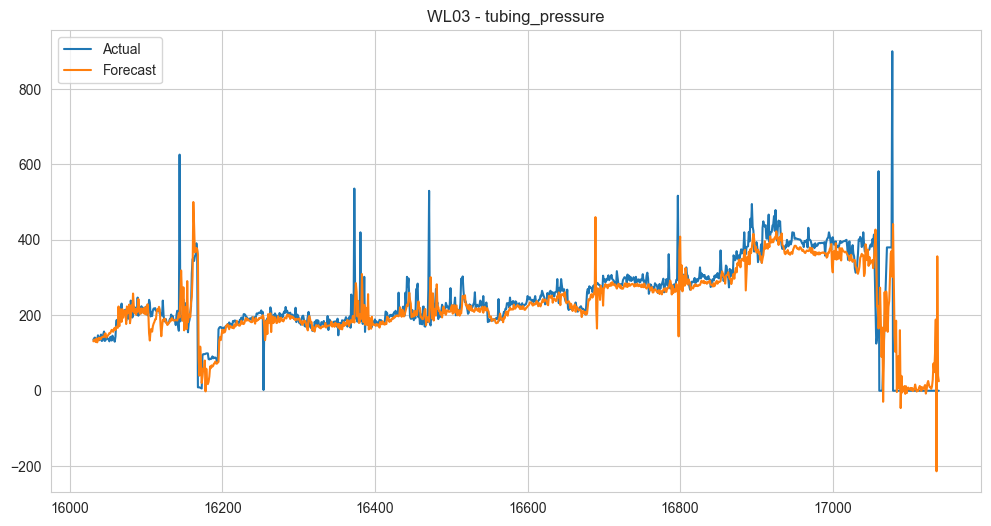

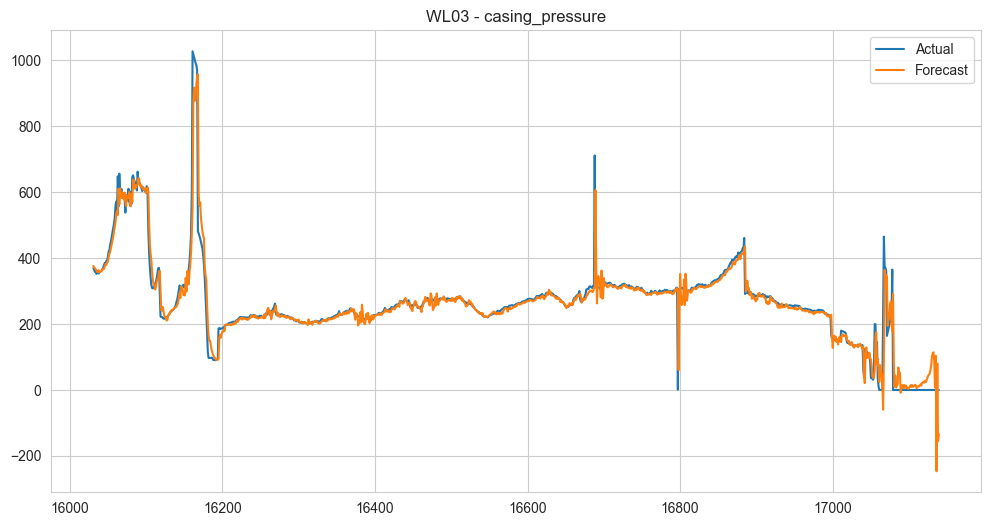

In [17]:
# Adjust the function to plot actual values vs forecasts
def plot_forecasts(actual_index, actual, forecast_index, forecasts, title):
    plt.figure(figsize=(12, 6))
    plt.plot(actual_index, actual, label='Actual')
    plt.plot(forecast_index, forecasts, label='Forecast')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Generate one-step ahead forecasts and plot actual values vs forecasts
for well in wells:
    # Get the training and test data for the well
    train = train_test_data[well]['train'].drop(columns=['timestamp', 'well_name'])
    test = train_test_data[well]['test'].drop(columns=['timestamp', 'well_name'])
    
    # Initial history is the training data
    history = [x for x in train.values]
    
    # Store the predictions
    predictions = []
    
    # For each observation in the test set
    for t in range(len(test)):
        # Convierte la historia a un array de NumPy
        history_np = np.array(history)

        # Generate a one-step ahead forecast
        forecast = models[well].forecast(steps=1, y=history_np)
        
        # Store the forecast
        predictions.append(forecast[0])
        
        # Add the actual observation to the history for the next forecast
        history.append(test.values[t])

    
    # Plot actual values vs forecasts for each variable
    for i, column in enumerate(test.columns):
        plot_forecasts(test.index, test[column], test.index, [pred[i] for pred in predictions], title=f'{well} - {column}')
